<a href="https://colab.research.google.com/github/jhyoo78/jhyoo78/blob/main/LSTM_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

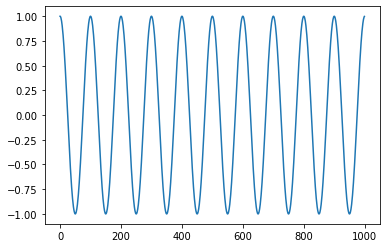

In [ ]:
# 참고 블로그  https://tykimos.github.io/2017/09/09/Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe/

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1000)*(20*np.pi/1000))[:,None] # np.cos(radian), 180 ==pi radian,
   # np.arange 사용법--> numpy.arange([start, ] stop, [step, ] dtype=None), step을 지정하지 않으면 1 단위로, start를 지정하지 않으면 0 부터...
   #[:, None]은 array에 차원을 하나 추가하라는 명령임. 예를 들어 [1,2,3]을 [[1], [2], [3]] 으로 바꾸어줌. numpy.newaxis를 참고하라.
plt.plot(np.arange(1000), signal_data) # 생성한 데이터 시각화,
# plt.plot(x,y), x,y는 list 여야 함

#print(np.cos(np.arange(1000)*(20*np.pi/1000)))
#plt.plot([1,555,777,888,900],[10, 12, 55, 23, 66])

In [ ]:
print(np.arange(100))
sig_data = np.cos(np.arange(1000)*(20*np.pi/1000))[:,None]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [ ]:
# 데이터를 모델로 학습시키기 위해서 전처리가 필요

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):        # look_back은 예측에 사용할 이전 데이터의 수,    signal_data가 train인 경우 700 - 40 = 660개
        dataX.append(signal_data[i:(i+look_back), 0])  # signal_data --> [[1.0], [0.999],... ] 등의 2차원 list
                                                       # signal_data[:, 0]은 위 모든 행에서 첫번째 열의 정보를 가져오라는 뜻 --> https://coo-coo2021.tistory.com/170
                                                       # dataX --> [[1.0. 0.999, ....]]로 40개의 데이터로 구성된 list를
                                                       # 하나씩 우측으로 옮기며 40개 씩 append [[40개], [40개]...]
        dataY.append(signal_data[i + look_back, 0])    # dataY --> 41번째 데이터 한개씩 추가 --> [0.09549, 0.07783...]
        #print("dataX=", dataX)
        #print("dataY=", dataY)
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []       # 객체 호출 시에 리스트 초기화
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):   # callback 함수의 logs는 dict를 사용함
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # cosine 값 -1 ~ 1.0 을 ==>  0.0 ~ 1.0으로 변환
signal_data = scaler.fit_transform(signal_data)
#print(signal_data)

# 데이터 분리
train = signal_data[0:700]
val = signal_data[600:700]
test = signal_data[700:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
#print("x_train=", x_train) --> 660개 x 40개의  2차원 리스트 출력
#print("y_train=", y_train) --> 660개 데이터의 1차원 리스트 출력
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)

In [ ]:
# 2. 모델 구성하기
model = Sequential()
#for i in range(2):
#    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True,
#                   return_sequences=True))
#    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(50):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False,
              callbacks=[custom_hist], validation_data=(x_val, y_val), verbose= 0)
    model.reset_states()


In [ ]:
# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [ ]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

In [ ]:
# 7. 모델 사용하기
look_ahead = 260
xhat = x_test[0]    # 40개의 2차원 데이터 --> [[1.0], [0.99901336], [0.99605735]...]
print("xhat_org=", x_test[0])

predictions = np.zeros((look_ahead,1))  # --> [[0.], [0.]...],  260개의 2차원 리스트

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)   #predict() : 임의의 입력(xhat)에 대한 모델의 출력값을 확인한다.
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction]) # np.vstack(a, b) 배열 a와 b를 수직으로 결합하여 출력,
                                            # x_test[0]의 데이터는 초기 39개부터 하나씩 줄고 prediction 데이터가 하나씩 추가됨
   #print("xhat=", xhat)
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()
